<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Dataset" data-toc-modified-id="Load-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Dataset</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Training-and-Testing" data-toc-modified-id="Training-and-Testing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training and Testing</a></span></li></ul></div>

In [1]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(1)    # reproducible

In [2]:
# Hyper Parameters
EPOCH = 1                 # train on the training data n times
BATCH_SIZE = 64
LR = 0.001                #  learning rate
DOWNLOAD_MNIST = True     # set to False if data is already downloaded

# Load Dataset

In [3]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='.tmp/mnist',
    train=True,  # this is training data
    transform=torchvision.transforms.ToTensor(
    ),  # Converts a PIL.Image or numpy.ndarray to
    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,  # download it if you don't have it
)

In [4]:
train_data.train_data.size()

torch.Size([60000, 28, 28])

In [5]:
train_data.train_labels.size()

torch.Size([60000])

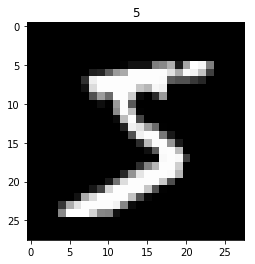

In [6]:
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [7]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (64, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
# Convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='.tmp/mnist/', train=False)
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1)).type(
    torch.FloatTensor)[:2000] / 255.
#test_x = test_x.cuda()  # Use the GPU
test_y = test_data.test_labels[:2000]
#test_y = test_y.cuda()

In [9]:
test_y


 7
 2
 1
⋮ 
 3
 9
 5
[torch.LongTensor of size 2000]

# Model

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,  # input height
                out_channels=16,  # n_filters
                kernel_size=5,  # filter size
                stride=1,  # filter movement/step
                padding=2,
                # if we want same width and length of this image after conv2d,
                # padding=(kernel_size-1)/ 2 if stride=1
            ),  # output shape (16, 28, 28)
            nn.ReLU(),  # activation
            nn.MaxPool2d(
                kernel_size=2
            )  # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(  # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )

        self.out = nn.Linear(32 * 7 * 7,
                             10)  # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(
            x.size(0),
            -1)  # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x

In [11]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d (1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d (16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (out): Linear(in_features=1568, out_features=10)
)


In [12]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR) # Optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                     # the target label is not one-hotted

In [13]:
from matplotlib import cm
from sklearn.manifold import TSNE

In [14]:
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
        
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.title('Visualize last layer')
    plt.show()
    plt.pause(0.01)

# Training and Testing

Epoch:  0 | train loss: 2.3081 | test accuracy: 0.19


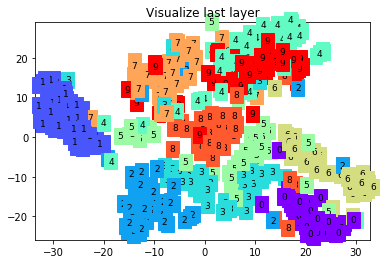

Epoch:  0 | train loss: 0.3601 | test accuracy: 0.89


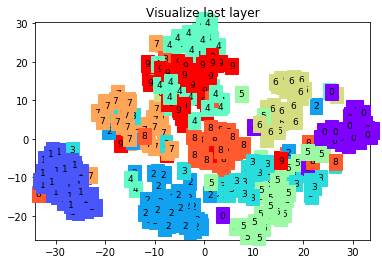

Epoch:  0 | train loss: 0.0998 | test accuracy: 0.93


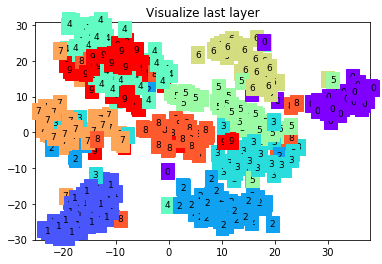

Epoch:  0 | train loss: 0.0988 | test accuracy: 0.94


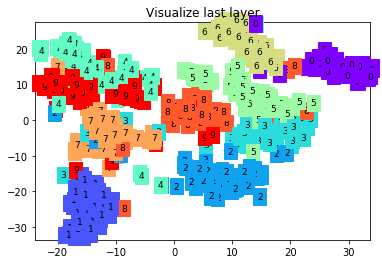

Epoch:  0 | train loss: 0.0712 | test accuracy: 0.96


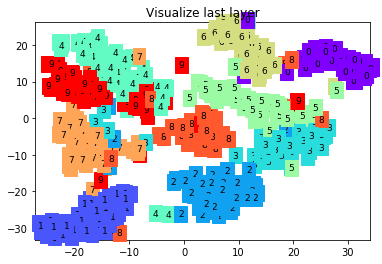

Epoch:  0 | train loss: 0.1260 | test accuracy: 0.96


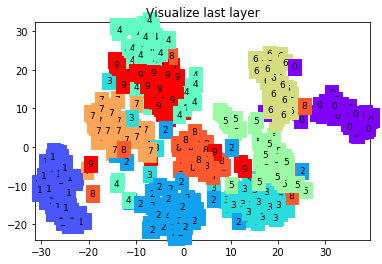

Epoch:  0 | train loss: 0.0424 | test accuracy: 0.97


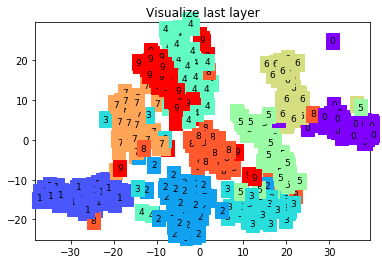

Epoch:  0 | train loss: 0.0304 | test accuracy: 0.97


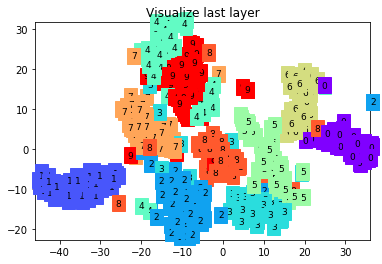

Epoch:  0 | train loss: 0.0297 | test accuracy: 0.97


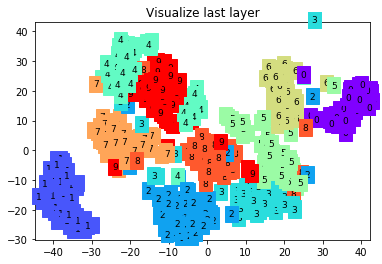

Epoch:  0 | train loss: 0.0357 | test accuracy: 0.98


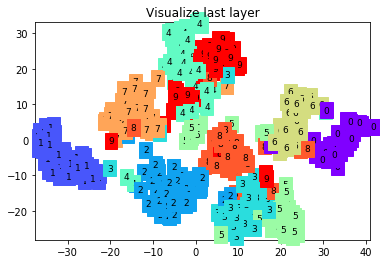

In [15]:
plt.ion()  # activate interactive mode
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        # gives batch data, normalize x when iterate train_loader
        b_x = Variable(x)  #.cuda()  # batch x
        b_y = Variable(y)  #.cuda()  # batch y

        output = cnn(b_x)[0]  # cnn output
        loss = loss_func(output, b_y)  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

        if step % 100 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data[0],
                  '| test accuracy: %.2f' % accuracy)

            # Visualization of trained flatten layer (T-SNE)
            tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
            plot_only = 500
            low_dim_embs = tsne.fit_transform(
                last_layer.data.numpy()[:plot_only, :])
            labels = test_y.numpy()[:plot_only]
            plot_with_labels(low_dim_embs, labels)

plt.ioff()

In [20]:
# print 20 predictions from test data
test_output, _ = cnn(test_x[:20])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'predicted number')
print(test_y[:20].numpy(), 'Actual number')

[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 5 4] predicted number
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4] Actual number


In [21]:
%load_ext version_information
%version_information torch, numpy, matplotlib

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.4 64bit [GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
IPython 6.2.1
OS Linux 4.13.0 32 generic x86_64 with debian stretch sid
torch 0.3.0.post4
numpy 1.14.0
matplotlib 2.1.2
Sun Feb 11 21:11:03 2018 CST